In [3]:
# Loading Libraries
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import log_hyperu as hyperu
import tgr as tgr
import math
import time
import csv
import re
import os

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Prediction Simulation Study
### Output Table

In [6]:

# Directory containing the Excel files
folder_path = 'Simulation_20240808_092415'

# Initialize an empty list to collect the data
summary_data = []

# Iterate through all Excel files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):
        # Extract sample size, features, and non-zero features from the file name
        match = re.match(r'loss_scen_(\d+)_(\d+)_(\d+)\.xlsx', file_name)
        if match:
            sample_size = int(match.group(1))
            features = int(match.group(2))
            non_zero_features = int(match.group(3))

            # Load the Excel file into a DataFrame
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_excel(file_path)

            # Compute median and standard deviation for each column
            medians = df.median()
            std_devs = df.std()

            # Collect the data into a dictionary
            data = {
                'sample_size': sample_size,
                'features': features,
                'non_zero_features': non_zero_features
            }

            # Add median and standard deviation to the dictionary
            for col in df.columns:
                data[f'{col}_median'] = medians[col]
                data[f'{col}_std_dev'] = std_devs[col]

            # Append the dictionary to the list
            summary_data.append(data)

# Convert the list of dictionaries into a DataFrame
summary_df = pd.DataFrame(summary_data)

# Save the summary DataFrame to a new Excel file if needed
summary_df.to_excel('summary_statistics.xlsx', index=False)

print(summary_df)


    sample_size  features  non_zero_features  OLS_median  OLS_std_dev  \
0          1000        10                  1    0.250438     0.019707   
1          1000        10                  5    0.240119     0.021908   
2          1000        10                  9    0.256303     0.025957   
3          1000        25                 13    0.258702     0.022057   
4          1000        25                 23    0.261452     0.029658   
5          1000        25                  3    0.252794     0.026742   
6          1000         3                  1    0.250530     0.026487   
7          1000         3                  2    0.251138     0.020769   
8          1000         3                  3    0.250342     0.028901   
9           100        10                  1    0.273401     0.079445   
10          100        10                  5    0.262372     0.090542   
11          100        10                  9    0.253864     0.102015   
12          100        25                 13    0.3

In [10]:
# Get Table to LATEX
df = pd.read_excel('summary_statistics.xlsx', sheet_name='Final')
latex_table = df.to_latex(index=False)
with open('latex_table_output.tex', 'w') as file:
    file.write(latex_table)


### Boxplot of Specific Scenario

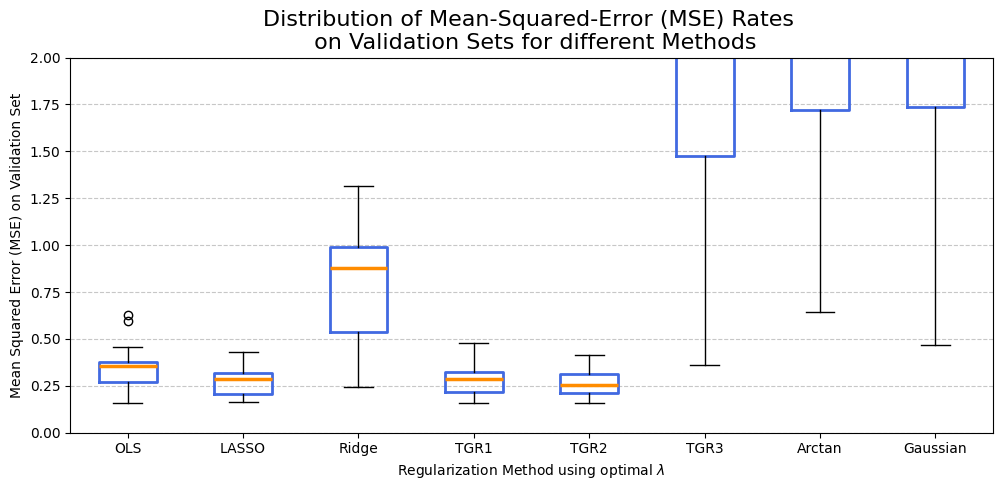

In [22]:
def ScenarioBoxplot(samples, features, non_zero_features, folder_path):
    file_name = f"loss_scen_{samples}_{features}_{non_zero_features}.xlsx"
    file_path = os.path.join(folder_path, file_name)
    
    if not os.path.exists(file_path):
        print(f"No file found for {file_name}")
        return
    
    df = pd.read_excel(file_path)
    columns_to_plot = ['OLS', 'LASSO', 'Ridge', 'TGR1', 'TGR2', 'TGR3','Arctan', 'Gaussian',]

    fig, ax = plt.subplots(figsize=(10, 5))
    boxprops = dict(linestyle='-', linewidth=2, color='royalblue')
    medianprops = dict(linestyle='-', linewidth=2.5, color='darkorange')

    plt.boxplot([df[col] for col in columns_to_plot], labels=columns_to_plot, boxprops=boxprops, medianprops=medianprops)
    plt.title('Distribution of Mean-Squared-Error (MSE) Rates \n on Validation Sets for different Methods', fontsize=16)
    plt.xlabel('Regularization Method using optimal $\\lambda$', fontsize=10)
    plt.ylabel('Mean Squared Error (MSE) on Validation Set', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines only for y-axis
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()  # Adjust layout to make room for labels
    plt.ylim((0,2))
    plt.savefig(f"021_simulation_figures/Scenarion_{samples}_{features}_{non_zero_features}.png")

# Example usage
folder_path = 'Simulation_20240808_092415'
ScenarioBoxplot(100, 25, 3, folder_path)


### Computational Performance

In [31]:
import itertools
import time

# Set random seed for reproducibility
torch.manual_seed(123) # 42
np.random.seed(123) # 42

# Step 1: Generate synthetic data using scenario
n_epochs = 500
runs = 1

n_samples = [100]
n_features = [i+1 for i in range(75)]
n_nonzero = [0.1]

scenario_combinations = list(itertools.product(n_samples, n_features, n_nonzero))
time_list = list()
# Make new simulation folder
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
simulation_folder_path = f'Simulation_{current_datetime}'
os.makedirs(simulation_folder_path, exist_ok=True)

counter=0
for scen in scenario_combinations:
    start_time = time.time()
    output_list = list() # Contains Tuples with (METHOD, LAMBDA, LOSS, COEFS)
    counter = counter + 1
    for run in range(runs):
        n_samples = scen[0]
        n_features = scen[1]
        n_nonzero = math.ceil(scen[2]*scen[1])
        # True coefficients with sparsity (many coefficients are zero)
        true_coefficients = torch.zeros(n_features)
        true_coefficients[:n_nonzero] = torch.randn(n_nonzero)

        # Generate features
        X = torch.randn(n_samples, n_features)

        # Generate targets with noise
        noise = torch.randn(n_samples) * 0.5
        y = X @ true_coefficients + noise

        # Step 2: Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Step 3: Implement OLS and Lasso regression using PyTorch

        class LinearRegression(nn.Module):
            def __init__(self, n_features):
                super(LinearRegression, self).__init__()
                self.linear = nn.Linear(n_features, 1, bias=False)
                
            def forward(self, x):
                return self.linear(x)

        def train_model(model, X_train, y_train, lr=0.01, n_epochs=500):
            criterion = nn.MSELoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            
            for epoch in range(n_epochs):
                model.train()
                
                optimizer.zero_grad()
                outputs = model(X_train).squeeze()
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()
                
            return model
        
        # Train TGR Model - Setting 1
        tgr_reg_strength = 0.02
        tgr_model1 = LinearRegression(n_features)
        def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
            mse_loss = nn.MSELoss()(output, target)
            phi = torch.tensor((2*c)/((kappa**2)*a))
            tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

            return mse_loss + tgr_loss

        optimizer = torch.optim.SGD(tgr_model1.parameters(), lr=0.01)

        for epoch in range(n_epochs):
            tgr_model1.train()
            
            optimizer.zero_grad()
            outputs = tgr_model1(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model1, tgr_reg_strength, 0.75, 0.1, 2)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model1.parameters(), 1.0)
            optimizer.step()
        
        # Train TGR Model - Setting 2
        tgr_model2 = LinearRegression(n_features)
        def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
            mse_loss = nn.MSELoss()(output, target)
            phi = torch.tensor((2*c)/((kappa**2)*a))
            tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

            return mse_loss + tgr_loss

        optimizer = torch.optim.SGD(tgr_model2.parameters(), lr=0.01)
        tgr_reg_strength = 0.04
        for epoch in range(n_epochs):
            tgr_model2.train()
            
            optimizer.zero_grad()
            outputs = tgr_model2(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model2, tgr_reg_strength, 5, 0.01, 2)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model2.parameters(), 1.0)
            optimizer.step()

        # Train TGR Model - Setting 3
        tgr_reg_strength = 0.13
        tgr_model3 = LinearRegression(n_features)
        def tgr_loss(output, target, model, tgr_reg_strength, a, c, kappa):
            mse_loss = nn.MSELoss()(output, target)
            phi = torch.tensor((2*c)/((kappa**2)*a))
            tgr_loss = tgr_reg_strength * torch.sum(-hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),(model.linear.weight**2)/(2*phi))+hyperu.log_hyperu(torch.tensor([[c+0.5]]),torch.tensor([[1.5-a]]),torch.tensor([[0.0]])))

            return mse_loss + tgr_loss

        optimizer = torch.optim.SGD(tgr_model3.parameters(), lr=0.01)

        for epoch in range(n_epochs):
            tgr_model3.train()
            
            optimizer.zero_grad()
            outputs = tgr_model3(X_train).squeeze()
            loss = tgr_loss(outputs, y_train, tgr_model3, tgr_reg_strength, 0.51, 0.01, 1)
            loss.backward()
            nn.utils.clip_grad_norm_(tgr_model3.parameters(), 1.0)
            optimizer.step()

        # END RUNS LOOP
    end_time = time.time()
    time_list.append((scen[1],round(end_time - start_time,5)))
    print(f"Scenario {scen[1]} done!")
        

df_time = pd.DataFrame(time_list, columns=['Variables', 'TimeInSeconds'])


Scenario (100, 1, 0.1) done!
Scenario (100, 2, 0.1) done!
Scenario (100, 3, 0.1) done!
Scenario (100, 4, 0.1) done!
Scenario (100, 5, 0.1) done!
Scenario (100, 6, 0.1) done!
Scenario (100, 7, 0.1) done!
Scenario (100, 8, 0.1) done!
Scenario (100, 9, 0.1) done!
Scenario (100, 10, 0.1) done!
Scenario (100, 11, 0.1) done!
Scenario (100, 12, 0.1) done!
Scenario (100, 13, 0.1) done!
Scenario (100, 14, 0.1) done!
Scenario (100, 15, 0.1) done!
Scenario (100, 16, 0.1) done!
Scenario (100, 17, 0.1) done!
Scenario (100, 18, 0.1) done!
Scenario (100, 19, 0.1) done!
Scenario (100, 20, 0.1) done!
Scenario (100, 21, 0.1) done!
Scenario (100, 22, 0.1) done!
Scenario (100, 23, 0.1) done!
Scenario (100, 24, 0.1) done!
Scenario (100, 25, 0.1) done!
Scenario (100, 26, 0.1) done!
Scenario (100, 27, 0.1) done!
Scenario (100, 28, 0.1) done!
Scenario (100, 29, 0.1) done!
Scenario (100, 30, 0.1) done!


KeyboardInterrupt: 